## Условие задачи

Найти машинное $\varepsilon$, число разрядов в мантиссе, максимальную и минимальную степени $e_{max}$, $e_{min}$ при вычислениях с обычной и двойной точностью. Сравнить друг с другом четыре числа: 1, $1 + \frac{\varepsilon}{2}$, $1 + \varepsilon$ и $1 + \varepsilon+ \frac{\varepsilon}{2}$, объяснить результат. Будут ли равны $(1 + 10^{−16}) + 10^{−16}$ и $1 + (10^{−16} + 10^{−16})$. Почему?


## Найдем машинный эпсилон


Что такое машинный $\varepsilon$? Это такой $\varepsilon$, что $1 + \varepsilon \not = 1 \land 1 +\frac{\varepsilon}{2} = 1$. То есть это минимальная разница в числе, которое может различать компьютер. Полагаю, что вместо $1 +\frac{\varepsilon}{2} = 1$ можно было взять условие $1 +\frac{\varepsilon}{1.5} = 1$ или $1 +\frac{\varepsilon}{1.1} = 1$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def available_floats():
    data_types = [np.float16, np.float32, np.float64]
    if np.float64 != np.longdouble:
        data_types.append(np.longdouble)
    return data_types

Решение перебрать самое очевидное.

In [4]:
def machine_epsilon(data_type):
    e = data_type(1)
    while 1 + e/2 != 1:
        e /= 2
    return e


for dtype in available_floats():
    fi = np.finfo(dtype)
    print(f"{dtype.__name__:>12s}: finfo.eps = {fi.eps:.7e}  |  machine_epsilon = {machine_epsilon(dtype):.7e}")

     float16: finfo.eps = 9.7656250e-04  |  machine_epsilon = 9.7656250e-04
     float32: finfo.eps = 1.1920929e-07  |  machine_epsilon = 1.1920929e-07
     float64: finfo.eps = 2.2204460e-16  |  machine_epsilon = 2.2204460e-16
  longdouble: finfo.eps = 1.0842022e-19  |  machine_epsilon = 1.0842022e-19


Проверим гипотезу, что можно было взять условие $1 +\frac{\varepsilon}{1.5} = 1$.

In [5]:
def machine_epsilon(data_type):
    e = data_type(1)
    while 1 + e/1.5 != 1:
        e /= 2
    return e


for dtype in available_floats():
    fi = np.finfo(dtype)
    print(f"{dtype.__name__:>12s}: finfo.eps = {fi.eps:.7e}  |  machine_epsilon = {machine_epsilon(dtype):.7e}")

     float16: finfo.eps = 9.7656250e-04  |  machine_epsilon = 4.8828125e-04
     float32: finfo.eps = 1.1920929e-07  |  machine_epsilon = 5.9604645e-08
     float64: finfo.eps = 2.2204460e-16  |  machine_epsilon = 1.1102230e-16
  longdouble: finfo.eps = 1.0842022e-19  |  machine_epsilon = 5.4210109e-20


numpy берет макрос \_\_DBL_EPSILON__ из C. gcc считает \_\_DBL_EPSILON__ следующим образом https://github.com/gcc-mirror/gcc/blob/38666cbccff5114e2f23930fae180f03c385eb45/gcc/c-family/c-cppbuiltin.cc#L279-L288.

## Найдем число разрядов в мантиссе

Мантисса - это часть числа с плавающей точкой, содержащая его значащие цифры. Тогда число можно записать как:

$$
x = \mu \cdot b^e,
$$

где  
$\mu = \pm \Bigl( \gamma_1 b^{-1} + \gamma_2 b^{-2} + \cdots + \gamma_t b^{-t} \Bigr)$ — мантисса,

$t$ - разрядность (точность) мантиссы,

$b$ - система счисления,

$e$ - порядок.

Кажется, что t - число, такое что $\gamma_{t+1} b^{-t-1} < \varepsilon$.

In [6]:
def digit_precision(data_type):
    e = machine_epsilon(data_type)
    t = 0
    while 10**(-t-1) >= e:
        t += 1
    return t

In [7]:
for dtype in available_floats():
    fi = np.finfo(dtype)
    print(f"{dtype.__name__:>12s}: finfo.precision ={fi.precision:3d}  |  precision = {digit_precision(dtype):3d}")

     float16: finfo.precision =  3  |  precision =   3
     float32: finfo.precision =  6  |  precision =   7
     float64: finfo.precision = 15  |  precision =  15
  longdouble: finfo.precision = 18  |  precision =  19


Но так как считали в десятично системе счисления, было получено не число разрядов в мантиссе, а точность мантиссы, то есть количество десятичных цифр, которые можно хранить без потерь.

Как получить число разрядов?

In [8]:
for dtype in available_floats():
    fi = np.finfo(dtype)
    print(f"{dtype.__name__:>12s}: finfo.nmant ={fi.nmant+1:3d}  |  bits = {int(np.ceil((digit_precision(dtype)) * np.log2(10)))}")

     float16: finfo.nmant = 11  |  bits = 10
     float32: finfo.nmant = 24  |  bits = 24
     float64: finfo.nmant = 53  |  bits = 50
  longdouble: finfo.nmant = 64  |  bits = 64


Есть отличия... Попробуем в обратную сторону - вычислим точность, используя функцию в numpy для вычисления количества разрядов мантиссы.

In [9]:
for dtype in available_floats():
    fi = np.finfo(dtype)
    print(f"{dtype.__name__:>12s}: finfo.precision ={fi.precision:3d}  |  precision_finfo.nmant = {int((fi.nmant*np.log10(2))):3d}")

     float16: finfo.precision =  3  |  precision_finfo.nmant =   3
     float32: finfo.precision =  6  |  precision_finfo.nmant =   6
     float64: finfo.precision = 15  |  precision_finfo.nmant =  15
  longdouble: finfo.precision = 18  |  precision_finfo.nmant =  18


Получается, что $precision = \lfloor \ bits \cdot \log_{10} {2} \rfloor$.

Тогда $bits \approx \lceil precision \cdot \log_{2} 10 \rceil$.

In [10]:
for dtype in available_floats():
    fi = np.finfo(dtype)
    print(f"{dtype.__name__:>12s}: finfo.nmant ={fi.nmant+1:3d}  |  bits = {int(np.ceil((digit_precision(dtype)) * np.log2(10))):3d}")

     float16: finfo.nmant = 11  |  bits =  10
     float32: finfo.nmant = 24  |  bits =  24
     float64: finfo.nmant = 53  |  bits =  50
  longdouble: finfo.nmant = 64  |  bits =  64


По-прежнему отличие на пару битов. В чем дело? Попробуем сразу высчитывать количество разрядов, а не десятичную точность, чтобы избавиться от приближений.

In [ ]:
def binary_precision(data_type):
    e = machine_epsilon(data_type)
    t = 0
    while 2**(-t-1) >= e:
        t += 1
    return t

In [53]:
for dtype in available_floats():
    fi = np.finfo(dtype)
                                                       # + 1 скрытый бит
    print(f"{dtype.__name__:>12s}: finfo.nmant ={fi.nmant+1:3d}  |  bits = {binary_precision(dtype):3d}")

     float16: finfo.nmant = 11  |  bits =  62
     float32: finfo.nmant = 24  |  bits =  75
     float64: finfo.nmant = 53  |  bits = 104
  longdouble: finfo.nmant = 64  |  bits = 115


/tmp/ipykernel_262162/1750167134.py:4: RuntimeWarning: overflow encountered in cast
  while 2**(-t+50) >= e:


Вычисленное число разрядов с фактическим совпало. 😎

## Найдем максимальную и минимальную степени $e_{max}$, $e_{min}$ при вычислениях с обычной и двойной точностью

Что такое $emin$, $emax$?

$b^{emin-1}$, $b^{emax}$ - пороги значений, где $b$ - система счислений. $emin$, $emax$ - степени этих порогов.

In [13]:
def emin(data_type):
    zero = data_type(0)
    x = 0
    while 2**(-x -1 ) > zero:
        x += 1
    return -x


def emin_tiny(data_type):
    zero = np.finfo(data_type).tiny
    x = 0
    while 2**(-x -1 ) > zero:
        x += 1
    return -x-1

In [14]:
for dtype in available_floats():
    fi = np.finfo(dtype)
    print(f"{dtype.__name__:>12s}: finfo.minexp ={fi.minexp:6d}  |  emin = {emin(dtype):6d} | emin_tiny = {emin_tiny(dtype):6d}" )

     float16: finfo.minexp =   -14  |  emin =    -24 | emin_tiny =    -14
     float32: finfo.minexp =  -126  |  emin =   -149 | emin_tiny =   -126
     float64: finfo.minexp = -1022  |  emin =  -1074 | emin_tiny =  -1022
  longdouble: finfo.minexp =-16382  |  emin =  -1074 | emin_tiny =  -1075


Использования нуля в условии не приближает к нахождению $emin$, хотя программа работает правильно, если ищу $emin$, зная машинный нуль (numpy.finfo.tiny). Это может быть связано с тем, что операции производятся не в $data_type$, а во встроенном $float$.

In [15]:
def emin(data_type):
    zero = data_type(0)
    v = data_type(1)
    x = 0
    while v / data_type(2) > zero:
        v = v / data_type(2)
        x += 1
    return -x-1


In [16]:
for dtype in available_floats():
    fi = np.finfo(dtype)
    print(f"{dtype.__name__:>12s}: finfo.minexp = {fi.minexp:6d}  |  emin = {emin(dtype):6d}" )

     float16: finfo.minexp =    -14  |  emin =    -25
     float32: finfo.minexp =   -126  |  emin =   -150
     float64: finfo.minexp =  -1022  |  emin =  -1075
  longdouble: finfo.minexp = -16382  |  emin = -16446


Вычисление в нужном типе данных $data_type$ не помогает. Это связано с тем, что нужно искать минимальную экспоненту $emin$ для нормализованных чисел. А я делю до 0 (всех нулей в битовом представлении), затрагивая субнормальные числа.

Если экспонента числа $=$ $0$, но мантисса $\not = $ $0$, число является субнормальным.

In [17]:
def float_to_binary_str(x):
    bit_dtype_map = {np.float16: np.uint16, np.float32: np.uint32, np.float64: np.uint64}

    if type(x) == np.longdouble:
        bytes_array = np.frombuffer(x.tobytes(), dtype=np.uint8)
        binary_str = (''.join(f'{b:08b}' for b in bytes_array[::-1]))
    else:
        bits = np.frombuffer(x.tobytes(), dtype=bit_dtype_map[type(x)])[0]
        binary_str = f"{bits:0{np.dtype(type(x)).itemsize*8}b}"
    return binary_str

def divide_binary_str(binary_x, dtype):
    sign = binary_x[0]
    exponent = binary_x[1:(len(binary_x)-binary_precision(dtype)+1)]
    mantissa = binary_x[-(binary_precision(dtype)-1):]
    return (sign, exponent, mantissa)

def is_subnormal(x):
    parted_binary_str = divide_binary_str(float_to_binary_str(x), type(x))
    if "1" not in parted_binary_str[1] and "1" in parted_binary_str[2]:
        return True
    return False

In [18]:
print(is_subnormal(np.float16(999)))
print(is_subnormal(np.float16(1e-5)))

False
True


Найдем $emin$.

In [ ]:
def emin(dtype):
    v = dtype(1)
    x = 0
    while not is_subnormal(v / dtype(2)):
        v = v / dtype(2)
        x += 1
    return -x

In [20]:
for dtype in available_floats():
    fi = np.finfo(dtype)
    print(f"{dtype.__name__:>12s}: finfo.minexp = {fi.minexp:6d}  |  emin = {emin(dtype):6d}" )

     float16: finfo.minexp =    -14  |  emin =    -14
     float32: finfo.minexp =   -126  |  emin =   -126
     float64: finfo.minexp =  -1022  |  emin =  -1022
  longdouble: finfo.minexp = -16382  |  emin = -16382


Лирическое отступление. В типах данных до longdouble

`1 бит знаковый | биты экспоненты | биты мантиссы`

В типе longdouble:

`1 бит знаковый | биты экспоненты | бит нормальности | биты мантиссы + биты сдвига`

longdouble на UNIX имеет 80 значащих битов, а может иметь 112. Но помещается этот тип данных в 128 бит (битами сдвига).

Я хотел это все учесть, обрезав до 80 или 112 бит, добавив бит нормальности в кортеж, который возвращает divide_binary_str.

Но! число 999 должно представляться так (теоретически):

`0 011111111111100 1 111100111000000000000000000000000000000000000000000000000000000`

но numpy его представляет как:

`0 000000000000000 0 111111100110101010011011001101001000000000010001111100111000000`

Я теперь не понимаю, почему $emin$ посчиталось правильно, ибо нормализовано ли число в 128-битном представление должно проверяться иначе от проверки для float16/32/64, проверив просто бит нормальности (a. k. a. integer bit).

In [21]:
def emax(dtype):
    x = 0
    value = dtype(1)
    while value < dtype('inf'):
        value *= dtype(2)
        x += 1
    return x

In [22]:
for dtype in available_floats():
    fi = np.finfo(dtype)
    print(f"{dtype.__name__:>12s}: finfo.maxexp = {fi.maxexp:6d}  |  emin = {emax(dtype):6d}" )

     float16: finfo.maxexp =     16  |  emin =     16
     float32: finfo.maxexp =    128  |  emin =    128
     float64: finfo.maxexp =   1024  |  emin =   1024
  longdouble: finfo.maxexp =  16384  |  emin =  16384


/tmp/ipykernel_262162/1175179095.py:5: RuntimeWarning: overflow encountered in scalar multiply
  value *= dtype(2)


## Сравнить друг с другом четыре числа: 1, $1 + \frac{\varepsilon}{2}$, $1 + \varepsilon$ и $1 + \varepsilon+ \frac{\varepsilon}{2}$, объяснить результат

In [23]:
for dtype in available_floats():
    e = machine_epsilon(dtype)
    print(dtype(1), dtype(1 + e / dtype(2)), dtype(1) + e, 1 + dtype(e) + dtype(e)/dtype(2))


1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0


$1$ и $1+\frac{\varepsilon}{2}$ по определению машинного эпсилона неотличимы, а $1 + \varepsilon$ и $1 + \varepsilon+ \frac{\varepsilon}{2}$ по определению машинного эпсилона отличимы от $1$.

Но почему тогда $1 + \varepsilon$ и $1 + \varepsilon+ \frac{\varepsilon}{2}$ отличимы друг от друга? По определению машинного эпсилона это минимальная разница между $1$ и следующим представимым числом, отличным от $1$. То есть это $\Delta$ между $1$ и следующим числом. Но $\Delta$ между $1+\varepsilon$ и следующим представимым числом не факт, что равна $\varepsilon$. Видимо, это $\Delta$ меньше, чем $\Delta$ для единицы.

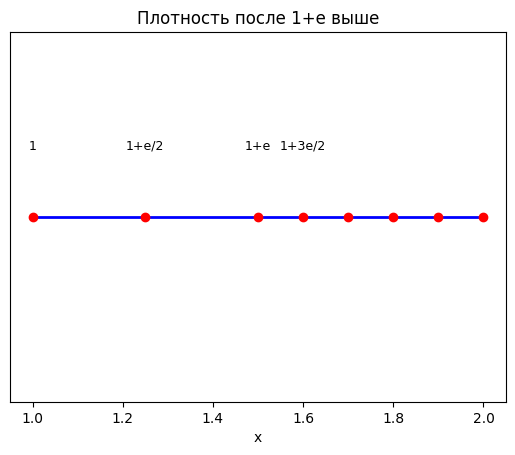

In [24]:
points = [1, 1.25, 1.5, 1.6, 1.7, 1.8, 1.9, 2]

plt.plot([1, 2], [0, 0], color='blue', linewidth=2)

plt.scatter(points, [0, 0, 0, 0, 0, 0, 0, 0], color='red', zorder=5)

plt.text(points[0], 0.02, '1', ha='center', fontsize=9)
plt.text(points[1], 0.02, '1+e/2', ha='center', fontsize=9)
plt.text(points[2], 0.02, '1+e', ha='center', fontsize=9)
plt.text(points[3], 0.02, '1+3e/2', ha='center', fontsize=9)

plt.yticks([])
plt.xlabel('x')
plt.title('Плотность после 1+e выше')
plt.grid(False)
plt.show()


На самом деле я неправ. Плотность уменьшется с ростом числа. Числа различимы просто из-за округления.

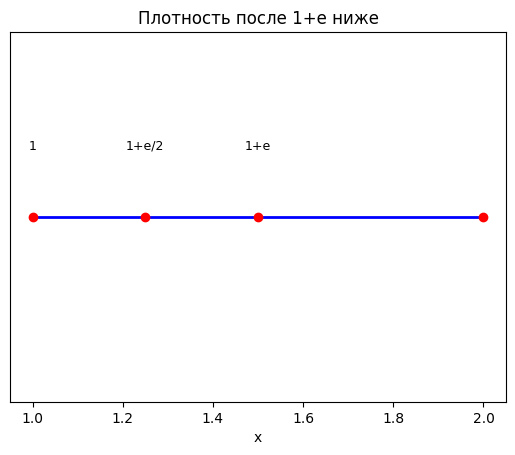

In [25]:
points = [1, 1.25, 1.5, 2]

plt.plot([1, 2], [0, 0], color='blue', linewidth=2)

plt.scatter(points, [0, 0, 0,  0], color='red', zorder=5)

plt.text(points[0], 0.02, '1', ha='center', fontsize=9)
plt.text(points[2], 0.02, '1+e', ha='center', fontsize=9)
plt.text(points[1], 0.02, '1+e/2', ha='center', fontsize=9)

plt.yticks([])
plt.xlabel('x')
plt.title('Плотность после 1+e ниже')
plt.grid(False)
plt.show()


## Будут ли равны $(1 + 10^{−16}) + 10^{−16}$ и $1 + (10^{−16} + 10^{−16})$

In [26]:
for dtype in available_floats():
    print((dtype(1) + dtype(10)**dtype(-16)) + dtype(10)**dtype(-16), 1 + ((dtype(10)**dtype(-16)) + dtype(10)**dtype(-16)))

1.0 1.0
1.0 1.0
1.0 1.0000000000000002
1.0000000000000001999 1.0000000000000002


Дело в том, что во всех типах, кроме longdouble $10^{-16} < e$, поэтому при сложении получается единица. Для float64 сумма двух десяток больше эпсилона.

В последнем случае для longdouble $1 + 10^{−16}$ - слишком мало, чтобы изменить последний бит мантиссы. При еще одном добавлении $10^{−16}$ по-прежнему число слишком мало, чтобы изменить последний бит.

А $2*10^{−16}$ достаточно большое, чтобы изменить последний бит мантиссы.

## Условие задачи
Рассчитайте сумму следующего ряда:
$1-\frac{1}{2} + \frac{1}{3} - ... +$
Чему равна эта сумма при $n \to \infty$? Как ведет себя относительная
погрешность при достаточно больших $n$ (точное решение = $ln(2)$)? Почему?

Ряд сходится условно по признаку Лейбница.

$$
S = 1 - \frac{1}{2} + \frac{1}{3} - \frac{1}{4} + \dots = \sum_{n=1}^{\infty} (-1)^{n+1} a_n, \quad a_n = \frac{1}{n}
$$

$$
S_n = \sum_{k=1}^{n} (-1)^{k+1} a_k
$$

$$
R_n = S - S_n = \sum_{k=n+1}^{\infty} (-1)^{k+1} a_k
$$

$$
|R_n| = |a_{n+1} - a_{n+2} + a_{n+3} - \dots| \le a_{n+1}
$$
Так как
$$
|a_{n+1} - (a_{n+2} - a_{n+3})>0 - \dots| \le a_{n+1}
$$

Заметим, что ряд является рядом тейлора для $\ln {(1 +x)}$, где $x=1$. Поэтому сумма ряда равняется $ln {2}$.

Определение относительной погрешности:
$$
\frac{|S - S_n|}{S}
$$

$$
\frac{|S - S_n|}{S} \le \frac{1}{(n+1)} \cdot \frac{1}{S} =  \frac{1}{(n+1)} \cdot \frac{1}{\ln 2}
$$

При $n \to \infty$:
$$
\frac{1}{(n+1)} \cdot \frac{1}{S} = 0
$$

Как рассчитать сумму для любого $n$?

Напомню, что:

$$
R_n = S - S_n
$$

Тогда $S_n = S - R_n = \ln 2 - R_n \le \ln 2 -\frac{1}{n+1}$

График частичных сумм ряда, вычисленных через остаточный член.

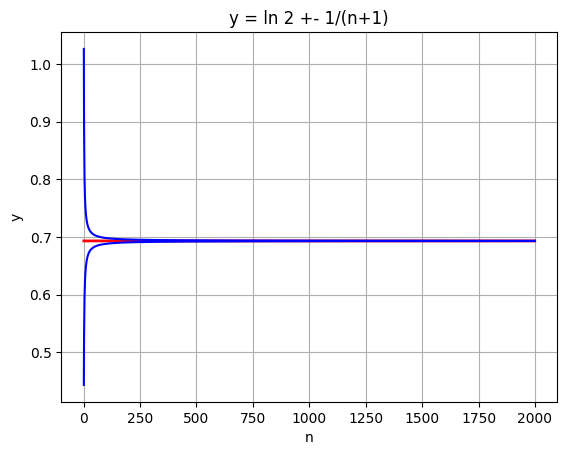

In [27]:
ns = np.arange(1, 2000)

ys_up = np.log(2) + 1 / ((2*ns) + 1)
ys_down = np.log(2) - 1 / ((2*ns+1) + 1)

plt.plot(ns, np.full((len(ns), ), np.log(2)), color='r', linewidth=2)
plt.plot(ns, ys_down, linestyle='-', color='b')
plt.plot(ns, ys_up, linestyle='-', color='b')
plt.title('y = ln 2 +- 1/(n+1)')
plt.xlabel('n')
plt.ylabel('y')
plt.grid(True)
plt.show()

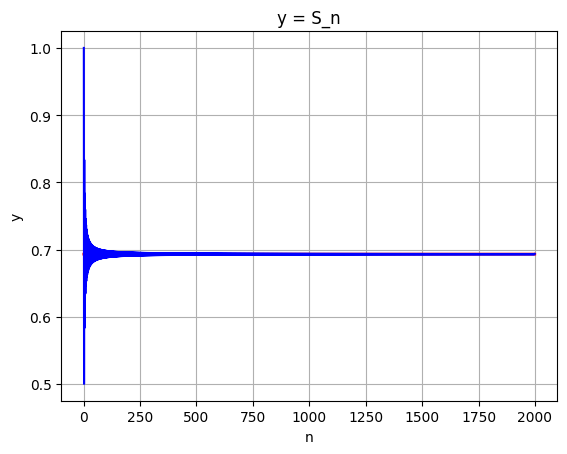

In [28]:
ns = np.arange(1, 2000)


ans = [(-1)**(i+1) * 1/i for i in ns]

sumn = 0
ys = []
for a in ans:
  sumn += a
  ys.append(sumn)

plt.plot(ns, np.full((len(ns), ), np.log(2)), color='r', linewidth=2)
plt.plot(ns, ys, linestyle='-', color='b')
plt.title('y = S_n')
plt.xlabel('n')
plt.ylabel('y')
plt.grid(True)
plt.show()

График относительной погрешности

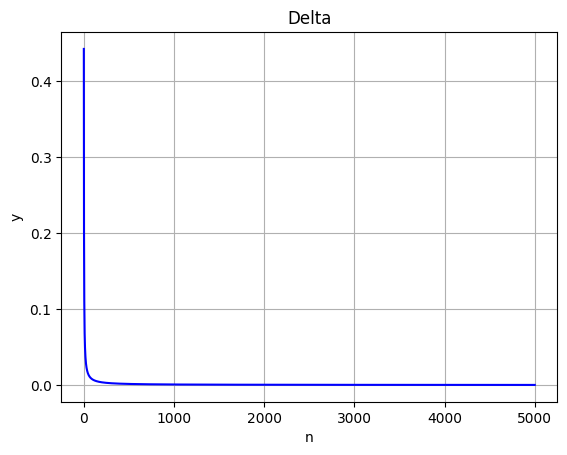

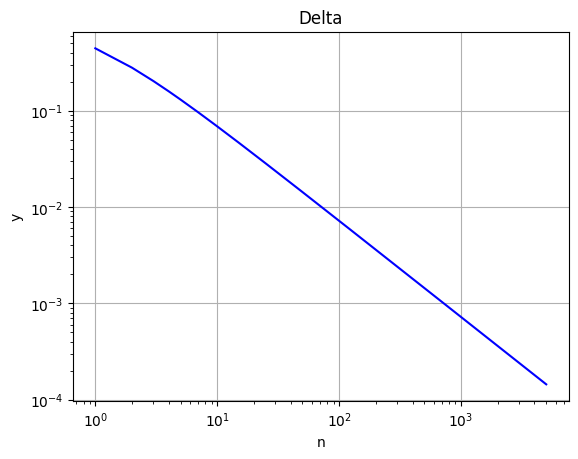

In [54]:
ns = np.arange(1, 5000)


ans = [(-1)**(i+1) * 1/i for i in ns]

sumn = 0
sumns = []
for a in ans:
  sumn += a
  sumns.append(sumn)
ys = [np.abs(np.log(2) - sumn)/ np.log(2) for sumn in sumns]

plt.plot(ns, ys, linestyle='-', color='b')
plt.title('Delta')
plt.xlabel('n')
plt.ylabel('y')
plt.grid(True)
plt.show()

plt.plot(ns, ys, linestyle='-', color='b')
plt.title('Delta')
plt.xlabel('n')
plt.ylabel('y')
plt.grid(True)
plt.xscale("log")
plt.yscale("log")

plt.show()

Чтобы достичь точности $10^{-p}$

$$
\frac{|\ln 2 - S_n|}{\ln 2} \le 10^{-p}
$$

Мы знаем, что 

$$
\frac{|\ln 2 - S_n|}{\ln 2} \le \frac{1}{(n+1)} \cdot \frac{1}{\ln 2}
$$

Тогда

$$
\frac{|\ln 2 - S_n|}{\ln 2} \le \frac{1}{(n+1)} \cdot \frac{1}{\ln 2} \le 10^{-p}
$$

Для $p=const$ 

$$
n \ge \frac{10^p}{\ln 2} -1
$$

Чтобы получить точность $p$, нужно вычислить $\approx 10^p$ точек.

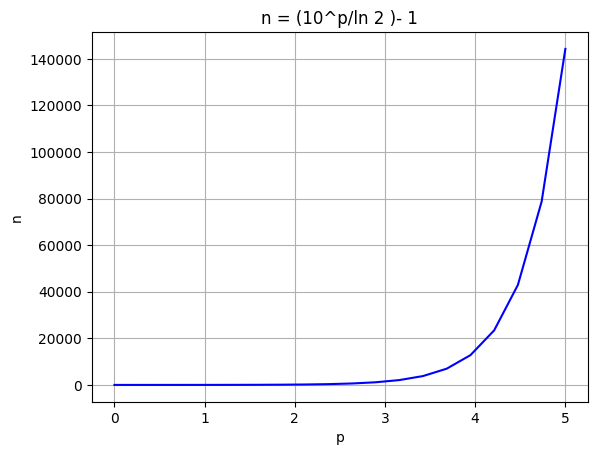

In [30]:
ps = np.linspace(0, 5, 20)

ns = (10**ps / np.log(2)) - 1

plt.plot(ps, ns, linestyle='-', color='b')
plt.title('n = (10^p/ln 2 )- 1')
plt.xlabel('p')
plt.ylabel('n')
plt.grid(True)
plt.show()

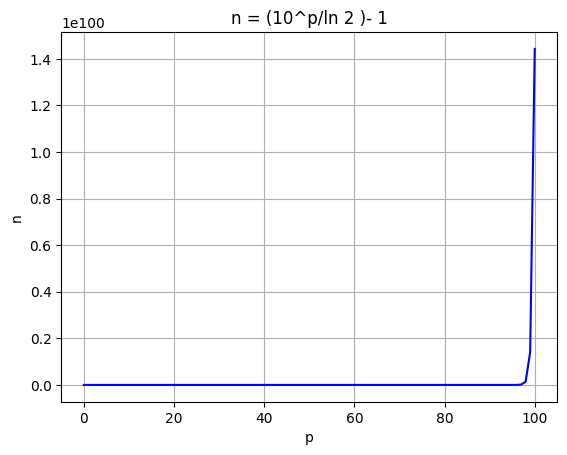

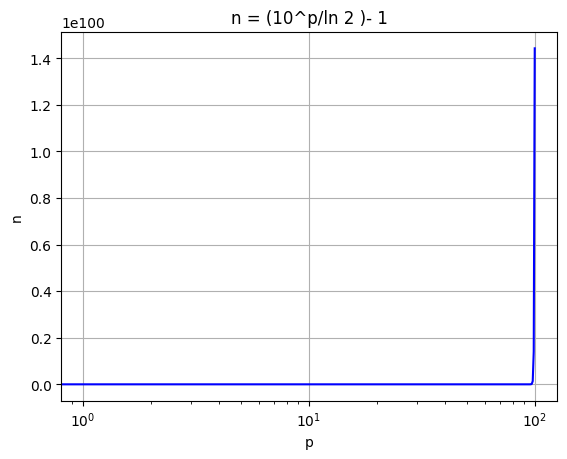

In [31]:
ps = np.linspace(0, 100, 100)

ns = (10**ps / np.log(2)) - 1

plt.plot(ps, ns, linestyle='-', color='b')
plt.title('n = (10^p/ln 2 )- 1')
plt.xlabel('p')
plt.ylabel('n')
plt.grid(True)
plt.show()

plt.plot(ps, ns, linestyle='-', color='b')
plt.title('n = (10^p/ln 2 )- 1')
plt.xlabel('p')
plt.ylabel('n')
plt.grid(True)
plt.xscale("log")
plt.show()

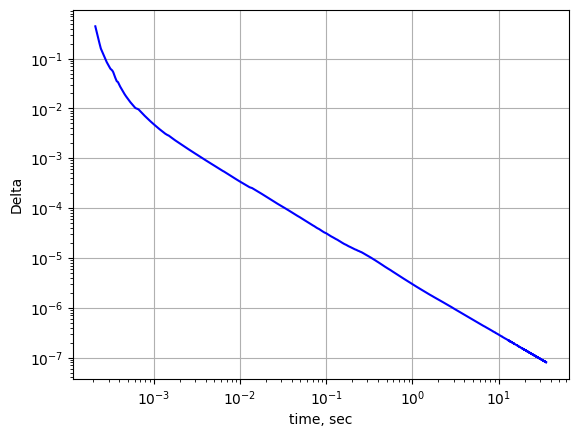

In [51]:
import time

ns = np.arange(1, 9000000)
ys = []

ts = []
sumn = 0
start = time.time()
for i in ns:
    sumn += (-1)**(i+1) * 1/i
    ys.append(np.abs(np.log(2) - sumn)/np.log(2))
    end = time.time()
    ts.append(end - start)


plt.plot(ts, ys, linestyle='-', color='b')
plt.xlabel('time, sec')
plt.ylabel('Delta')
plt.grid(True)
plt.yscale("log")
plt.xscale("log")
plt.show()